本案例仅仅用于演示和测试`alphalens`包，策略本身并没有实际意义

In [ ]:
%load_ext zipline

### 运行策略

In [ ]:
%%zipline --start 2018-1-1 --end 2018-5-2 -o result.pkl

import talib
import numpy as np
import math
import logbook

from zipline.api import *
from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.builtin import TopAverageAmount
from zipline.pipeline.factors import RSI

from zipline.finance import commission, slippage

log = logbook.Logger('RSI')


def make_pipeline():

    return Pipeline(
        columns={
            'rsi': RSI(window_length=15),
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(500))


# Setup our variables
def initialize(context):
    # 设置手续费及滑点
    set_commission(commission.PerShare(cost=0))
    set_slippage(slippage.FixedSlippage(spread=0))
    
    context.max_notional = 100000
    context.intc = sid(333)  #symbols(['000333','000002','300017'])
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    attach_pipeline(make_pipeline(), 'rsi_pipeline')
    schedule_function(rebalance, date_rules.every_day(),
                      time_rules.market_open())


def before_trading_start(context, data):
    #context.output = pipeline_output('rsi_pipeline')
    #print(context.output.head())
    pass

def rebalance(context, data):
    # 接收pipeline输出结果
    output = pipeline_output('rsi_pipeline')

    # Get our current positions
    positions = context.portfolio.positions
    
    # 信号触发可卖出和可买入的股票
    signal_sell = output[output['rsi'] > context.HIGH_RSI].index
    signal_buy = output[output['rsi'] < context.LOW_RSI].index
    
    for s in signal_sell:
        # 存在于持有的头寸中
        if s in positions:
            # 清空头寸
            order_target(s, 0)
            # amount代表持仓数量，而非金额
            current_intel_shares = positions[s].amount
            log.info('RSI is at ' + str(s) + ', 卖出 ' +
                     str(current_intel_shares) + ' shares')
            
    for s in signal_buy:
        # 对于信号提示可买入，但尚未买入的股票，买入固定金额
        if s not in positions:
            o = order_target_value(s, context.max_notional)
            log.info('RSI is at ' + str(s) + ', 买入 ' +
                     str(get_order(o).amount) + ' shares')

    # record the current RSI value and the current price of INTC.
    # record(intcRSI=intc_rsi, intcPRICE=data.current(context.intc, 'close'))

### 投资组合分析

In [1]:
import pyfolio as pf
import pandas as pd
#import empyrical as ep

#### 提取指标

In [2]:
results = pd.read_pickle('result.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

ModuleNotFoundError: No module named 'zipline'

#### 单图例子
绘制排名前5位的回撤周期

In [ ]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('日期')

#### 完整`tear sheet`(工作底稿)示例
为算法创建一个完整的工作表。例如，将实时开始日期设置为任意值。

**一般而言，`live_start_date`应设置接近回测结束日期**

Stress Events,mean,min,max
New Normal,0.15%,-18.42%,17.45%


/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


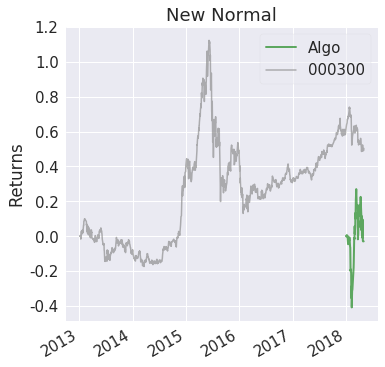

Top 10 long positions of all time,max
sid,
000807,6.42%
000878,6.06%
600711,5.56%
000806,5.36%
600497,4.91%
600715,4.24%
300134,2.69%
002864,2.05%
300618,1.86%


Top 10 short positions of all time,max
sid,
300073,-2.84%
603080,-2.46%
600490,-2.16%
000998,-1.06%


Top 10 positions of all time,max
sid,
000807,6.42%
000878,6.06%
600711,5.56%
000806,5.36%
600497,4.91%
600715,4.24%
300073,2.84%
300134,2.69%
603080,2.46%


All positions ever held,max
sid,
000807,6.42%
000878,6.06%
600711,5.56%
000806,5.36%
600497,4.91%
600715,4.24%
300073,2.84%
300134,2.69%
603080,2.46%


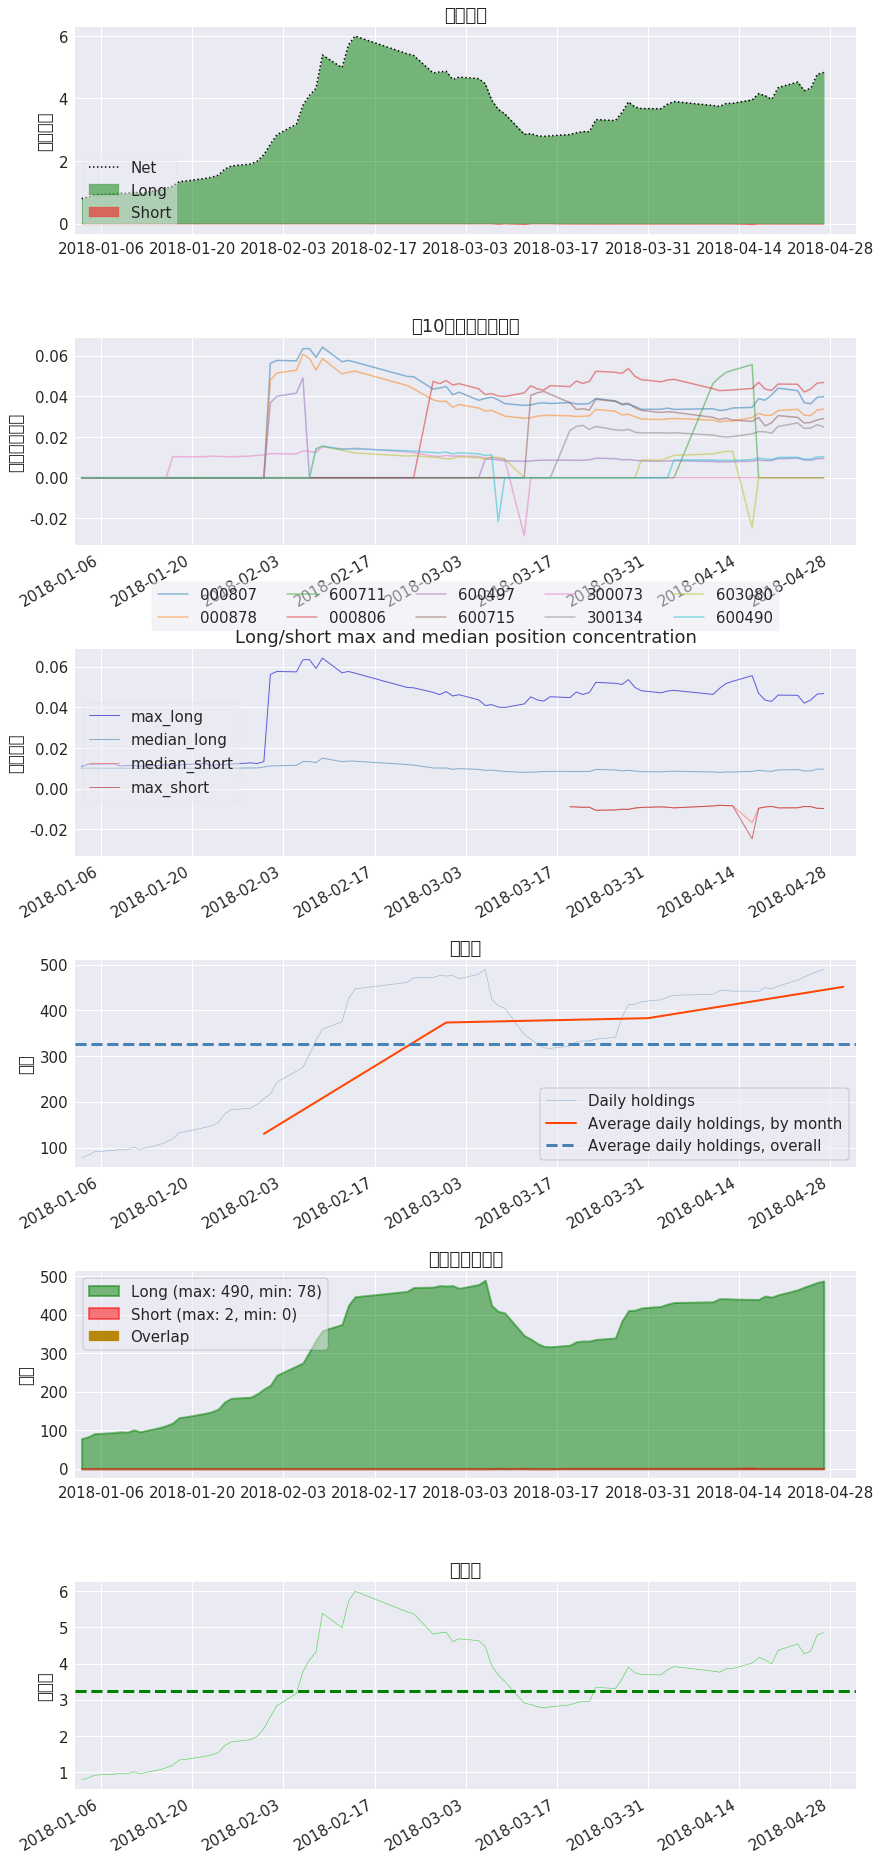

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


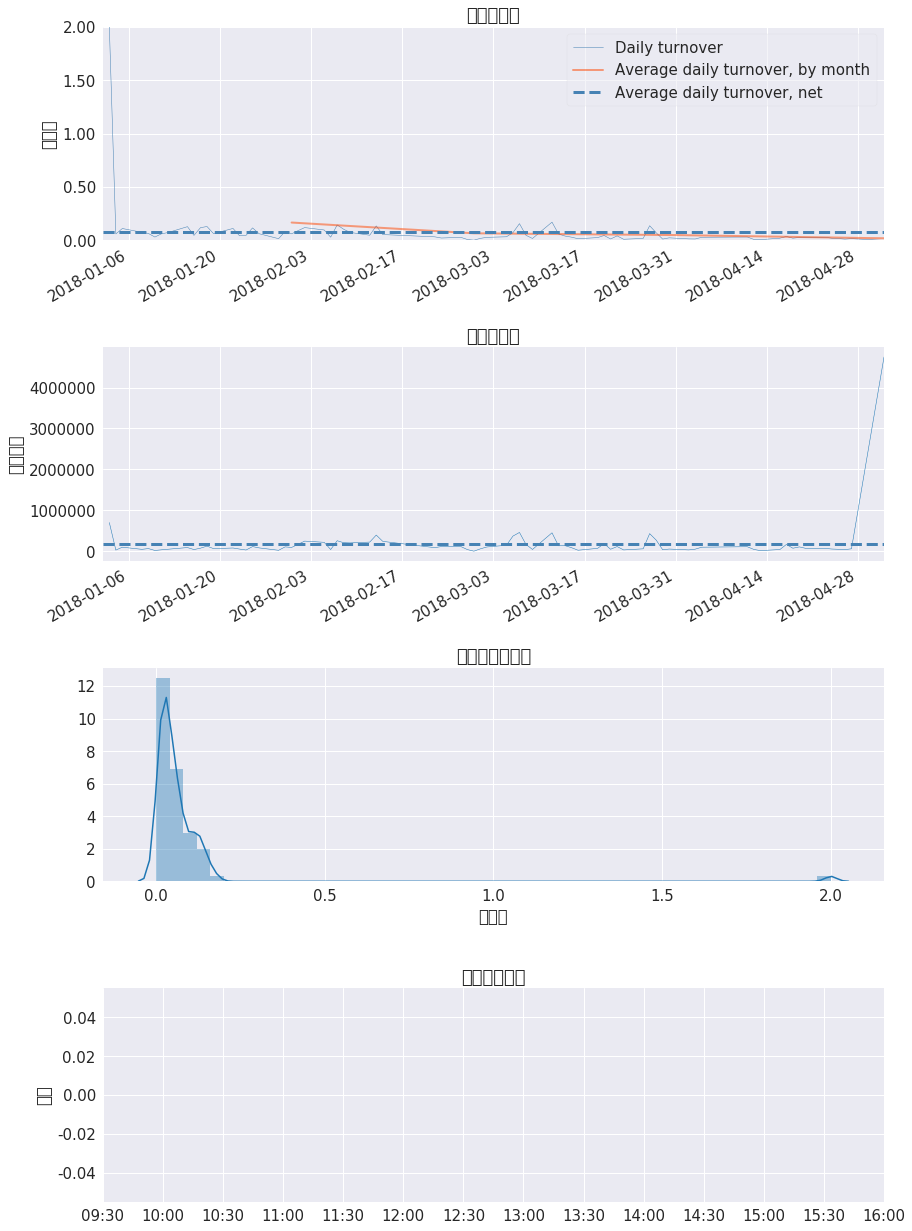

/home/ldf/source/pyfolio/pyfolio/round_trips.py:308: RuntimeWarning: divide by zero encountered in true_divide
  ending_price = ending_val / ending_amount
/home/ldf/source/pyfolio/pyfolio/round_trips.py:213: UserWarning: Negative price detected, ignoring forround-trip.
  warnings.warn('Negative price detected, ignoring for'
/home/ldf/source/pyfolio/pyfolio/round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/home/ldf/source/pyfolio/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/home/ldf/source/pyfolio/pyfolio/round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/home/ldf/source/pyfolio/pyfolio/round_trips.py:90: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='colum

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,796.00,4.00,792.00
Percent profitable,0.46,0.75,0.45
Winning round_trips,363.00,3.00,360.00
Losing round_trips,427.00,1.00,426.00
Even round_trips,6.00,0.00,6.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-390385.50,$31054.96,$-421440.46
Gross profit,$4370210.99,$38676.58,$4331534.41
Gross loss,$-4760596.49,$-7621.62,$-4752974.87
Profit factor,$0.92,$5.07,$0.91
Avg. trade net profit,$-490.43,$7763.74,$-532.12
Avg. winning trade,$12039.15,$12892.19,$12032.04
Avg. losing trade,$-11148.94,$-7621.62,$-11157.22
Ratio Avg. Win:Avg. Loss,$1.08,$1.69,$1.08
Largest winning trade,$119467.14,$27506.20,$119467.14
Largest losing trade,$-218791.70,$-7621.62,$-218791.70


Duration stats,All trades,Short trades,Long trades
Avg duration,50 days 21:42:30.753768,11 days 18:00:00,51 days 02:27:16.363636
Median duration,42 days 00:00:00,1 days 00:00:00,42 days 00:00:00
Longest duration,119 days 00:00:00,44 days 00:00:00,119 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,2 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.08%,0.07%,0.08%
Avg returns winning,0.12%,0.13%,0.12%
Avg returns losing,-0.08%,-0.06%,-0.08%
Median returns all round_trips,0.07%,0.02%,0.07%
Median returns winning,0.09%,0.13%,0.09%
Median returns losing,-0.07%,-0.06%,-0.07%
Largest winning trade,1.01%,0.25%,1.01%
Largest losing trade,-0.25%,-0.06%,-0.25%


Symbol stats,000001,000002,000006,000012,000016,000021,000025,000036,000039,000050,000055,000059,000060,000063,000066,000069,000100,000151,000155,000157,000166,000333,000338,000401,000402,000410,000413,000423,000425,000426,000488,000503,000513,000517,000519,000528,000532,000537,000538,000568,000581,000587,000596,000608,000615,000623,000625,000627,000636,000651,000661,000670,000671,000672,000703,000709,000717,000718,000725,000728,000729,000732,000735,000759,000761,000768,000776,000783,000786,000789,000792,000793,000799,000800,000806,000807,000816,000820,000823,000825,000830,000839,000856,000858,000868,000876,000877,000878,000895,000898,000926,000932,000933,000935,000936,000938,000955,000960,000961,000963,000970,000977,000979,000983,000996,000997,000998,001965,001979,002001,002008,002016,002019,002023,002024,002027,002036,002045,002049,002050,002054,002056,002063,002065,002073,002078,002079,002081,002092,002102,002110,002128,002129,002131,002137,002142,002146,002151,002152,002153,002156,002176,002178,002179,002185,002192,002194,002195,002202,002208,002214,002217,002221,002222,002223,002226,002230,002235,002236,002241,002244,002245,002251,002261,002264,002265,002268,002271,002273,002281,002285,002294,002302,002304,002307,002310,002320,002321,002323,002340,002354,002367,002369,002371,002382,002396,002400,002402,002405,002408,002409,002415,002422,002424,002428,002429,002436,002439,002440,002447,002450,002456,002457,002460,002466,002475,002477,002497,002500,002506,002508,002509,002512,002517,002547,002555,002573,002583,002594,002597,002600,002606,002610,002635,002648,002649,002650,002657,002670,002673,002676,002694,002714,002716,002736,002742,002769,002797,002807,002839,002856,002863,002864,002893,002895,002902,002906,002907,002908,002910,002911,002912,002915,002916,002917,002918,002919,002920,002922,002923,002925,002926,002928,002929,300009,300014,300015,300017,300024,300027,300033,300044,300053,300054,300055,300059,300070,300072,300073,300077,300083,300088,300101,300102,300104,300107,300110,300113,300115,300122,300124,300128,300134,300136,300137,300142,300156,300176,300181,300182,300183,300203,300212,300216,300223,300229,300231,300236,300251,300267,300274,300277,300315,300316,300323,300340,300343,300344,300355,300364,300367,300373,300377,300383,300386,300409,300418,300431,300433,300450,300451,300458,300466,300468,300477,300487,300496,300498,300520,300542,300590,300612,300618,300639,300644,300663,300664,300666,300675,300676,300677,300682,300684,300688,300698,300699,300706,300708,300711,300721,300723,300725,300726,300727,300730,300731,300732,300735,300737,300738,300741,600000,600008,600009,600010,600015,600016,600018,600019,600023,600025,600028,600029,600030,600031,600036,600038,600048,600050,600056,600060,600066,600068,600079,600085,600089,600093,600104,600109,600110,600111,600113,600115,600123,600125,600141,600150,600153,600155,600160,600161,600162,600171,600172,600176,600177,600179,600183,600187,600188,600196,600197,600198,600201,600206,600207,600208,600209,600216,600219,600230,600231,600256,600259,600260,600271,600282,600291,600295,600298,600325,600326,600330,600332,600333,600340,600345,600348,600352,600360,600362,600380,600383,600388,600392,600406,600409,600426,600435,600436,600438,600446,600460,600466,600487,600489,600490,600497,600498,600499,600507,600516,600518,600519,600520,600521,600522,600547,600549,600567,600569,600570,600577,600581,600584,600588,600594,600596,600598,600600,600606,600621,600634,600635,600643,600645,600660,600667,600673,600685,600688,600690,600698,600699,600702,600703,600705,600708,600711,600715,600720,600740,600741,600755,600760,600770,600779,600782,600787,600789,600797,600801,600803,600804,600808,600809,600810,600822,600823,600835,600837,600846,600867,600868,600874,600884,600887,600893,600900,600901,600903,600908,600909,600919,600926,600933,600958,600970,600971,600977,600999,601001,601006,601009,601011,601012,601015,601069,601088,601099,601101,601108,601111,601116,601117,601128,601139,601155,601166,6011

Profitability (PnL / PnL total) per name,
symbol,
600715,56.05%
000807,16.04%
000878,14.73%
600581,12.83%
002606,11.53%
300677,11.37%
603225,11.04%
002321,10.50%
002863,9.77%


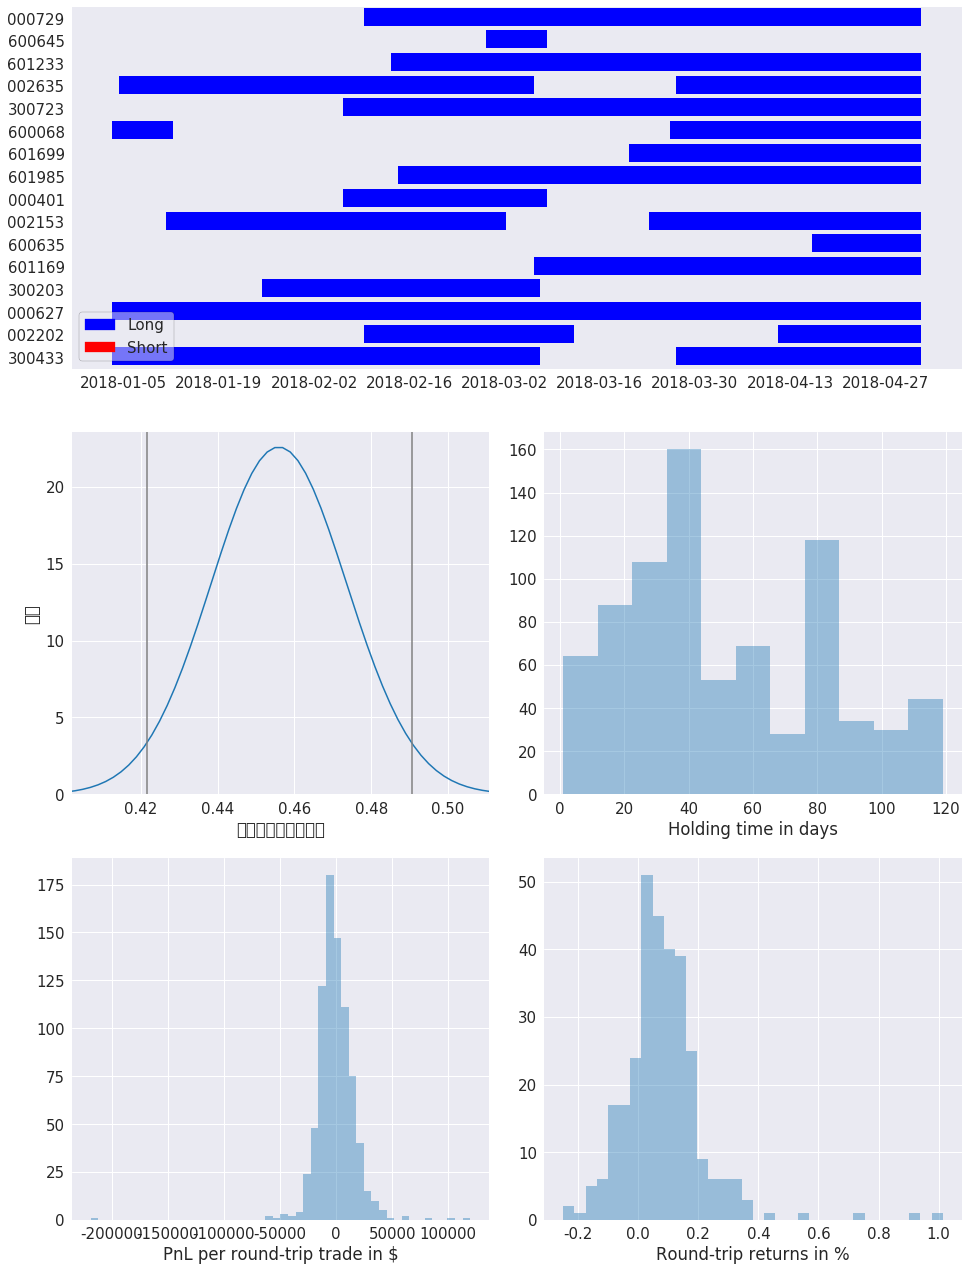

In [3]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2018-04-10', round_trips=True)

### 整理及补充数据

#### 使用研究模块提取数据
+ 如果存在分红派息，自动调整期间股价
+ 必须与回测期间相同

from zipline.research import run_pipeline

from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.builtin import TopAverageAmount

def make_pipeline():

    return Pipeline(
        columns={
            'close': USEquityPricing.close.latest,
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(500))

pipe_output = run_pipeline(make_pipeline(), '2018-1-1', '2018-5-2')

#### 整理数据

# 价格数据必须转换为日期为Index,stock为列名称的宽表
prices = pipe_output.unstack()['close']

prices.head()

factors = pipe_output['sector']
# 行业分类因子期间内不会改变，类型为整数
factors.fillna(method='bfill',inplace=True)
factors.fillna(method='ffill',inplace=True)
factors = factors.astype('int64')

factors.head()

### 因子分析

In [ ]:
from alphalens.utils import get_clean_factor_and_forward_returns

In [ ]:
get_clean_factor_and_forward_returns(factor=factors, prices=prices,max_loss=0)